In [1]:
data_file_path = '/content/drive/My Drive/Colab Notebooks/datasets/jena_climate_2009_2016.csv'

In [2]:
f = open(data_file_path)
data = f.read()
f.close()

In [3]:
data_lines = data.split('\n')

In [4]:
header = data_lines[0].split(',')

In [5]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [6]:
data_lines = data_lines[1:]

In [7]:
import numpy as np

In [8]:
float_data = np.zeros((len(data_lines), len(header) - 1))
for idx, line in enumerate(data_lines):
  value = [float(x) for x in line.split(',')[1:]]
  float_data[idx, :] = value

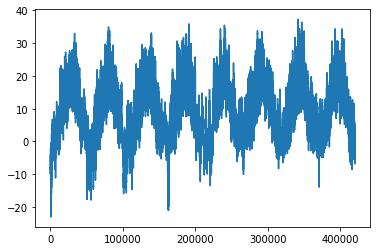

In [9]:
import matplotlib.pyplot as plt

temperature = float_data[:,1]
plt.plot(range(len(temperature)), temperature)

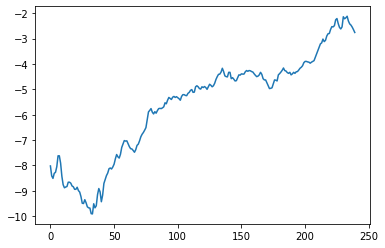

In [10]:
plt.plot(range(10 * 24 ), temperature[:10*24])

In [11]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

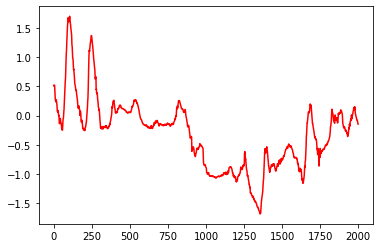

In [12]:
Ulim = 202000
Llim = 200000
SamSize = Ulim - Llim

plt.plot(range(SamSize), temperature[Llim:Ulim], 'r')

In [13]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [14]:
train_gen = generator(float_data, 1440, 144, min_index=200001, max_index=300000, shuffle=True)

In [15]:
validation_gen = generator(float_data, 1440, 144, min_index=200001, max_index=300000)

In [16]:
test_gen = generator(float_data, 1440, 144, min_index=300000, max_index=None)

In [17]:
val_steps = (300000 - 200001 - 1440) // 128 
test_steps = (len(float_data) - 300001 - 1440) // 128  

In [18]:
val_steps, test_steps

(769, 930)

In [19]:
from keras.models import Sequential
from keras import layers

In [20]:
model = Sequential([
    layers.LSTM(32, input_shape=(None,float_data.shape[-1])),
    layers.Dense(1)
])

In [21]:
model.compile(loss='mse', metrics=['mae'])

In [23]:
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=validation_gen, validation_steps=val_steps)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 18s 36ms/step - loss: 0.1277 - mae: 0.2770 - val_loss: 0.1022 - val_mae: 0.2485
Epoch 2/20
500/500 [==============================] - 17s 35ms/step - loss: 0.0925 - mae: 0.2350 - val_loss: 0.0885 - val_mae: 0.2290
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.0762 - mae: 0.2127 - val_loss: 0.0688 - val_mae: 0.2024
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.0639 - mae: 0.1952 - val_loss: 0.0561 - val_mae: 0.1835
Epoch 5/20
500/500 [==============================] - 17s 33ms/step - loss: 0.0545 - mae: 0.1808 - val_loss: 0.0492 - val_mae: 0.1724
Epoch 6/20
500/500 [==============================] - 17s 33ms/step - loss: 0.0468 - mae: 0.1675 - val_loss: 0.0439 - val_mae: 0.1624
Epoch 7/20
500/500 [==============================] - 16s 33ms/step - loss: 0.0415 - mae: 0.1577 - val_loss: 0.0386 - va